伊斯坦布尔证券交易所

数据导入

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data_akbilgic.csv")

df = df[['date', 'EU']].copy()

df.head()

,date,EU
0,2009-01-05 00:00:00,0.012698
1,2009-01-06 00:00:00,0.011341
2,2009-01-07 00:00:00,-0.017073
3,2009-01-08 00:00:00,-0.005561
4,2009-01-09 00:00:00,-0.010989


数据预处理

1.处理缺失值

In [33]:
print(df.isnull().sum())    # 返回每一列中的缺失值（NaN）的数量
print(df.isnull().any(axis=1))  # 返回一个布尔序列，标识每一行是否含有缺失值
print(df.iloc[105])   # 查看具体某一行的值，可以通过索引或者iloc属性来实现
print(df.iloc[106])

df['date'] = pd.to_datetime(df['date'])
# 计算相邻时间间隔
time_diff = df['date'].diff()

# 检查是否存在缺失值
if time_diff.isnull().any():
    print("数据中存在时间间隔缺失。")
else:
    print("数据中不存在时间间隔缺失。")

date    0
EU      0
dtype: int64
0      False
1      False
2      False
3      False
4      False
       ...  
531    False
532    False
533    False
534    False
535    False
Length: 536, dtype: bool
date    2009-06-04 00:00:00
EU                 0.001199
Name: 105, dtype: object
date    2009-06-05 00:00:00
EU                 0.006255
Name: 106, dtype: object
数据中存在时间间隔缺失。


2.处理日期类型

In [3]:
# 2. 数据类型转换
df['date'] = pd.to_datetime(df['date'])

# 3. 设定索引
df = df.set_index('date')

# 4. 检查数据排序
df = df.sort_index()

df.head()

,EU
date,
2009-01-05,0.012698
2009-01-06,0.011341
2009-01-07,-0.017073
2009-01-08,-0.005561
2009-01-09,-0.010989


数据分析

1.探索性数据分析（EDA）

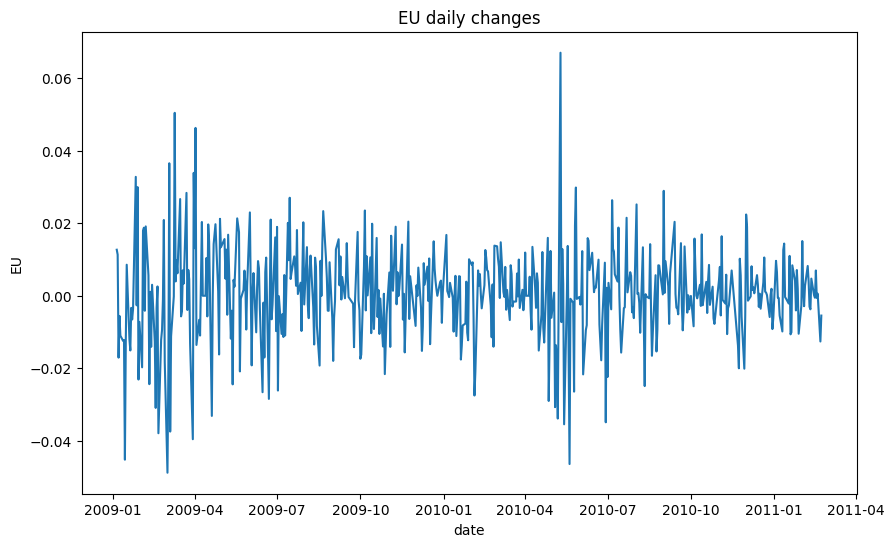

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df['EU'])
plt.xlabel('date')
plt.ylabel('EU')
plt.title('EU daily changes')
plt.show()

2.ADF单位根检验

In [5]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['EU'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -22.872896
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


3.差分

In [6]:
# 首先导入了所需要的库和函数
from statsmodels.tsa.stattools import adfuller

# 定义一个名为calculate_diff的函数，接收三个参数：df是要处理的DataFrame，max_diff是最大的差分步数，significance_level是判定平稳性的显著性水平
def calculate_diff(df, max_diff, significance_level=0.05):
    # 初始化最佳差分阶数和最小p值
    best_diff = None
    min_pvalue = 1.0
    min_variance = float('inf')  # 初始化最小方差
    min_adf_stat = float('inf')  # 初始化最小ADF统计量

    # 原数据
    # 对数据进行ADF单位根检验
    result = adfuller(df)
    # 打印出差分阶数，ADF统计量，p值，标准差和方差
    print('原数据')
    print('ADF统计量: %f' % result[0])
    print('p值: %.10e' % result[1])  
    print('标准差: %f' % df.std())
    print('方差: %f' % df.var())

    # 判断p值是否小于显著性水平，如果小于则认为差分后的数据可能是平稳的
    if result[1] < significance_level:
        print('=> 根据这个差分阶数，序列可能是平稳的')
        # 判断当前的p值是否小于最小p值，如果小于则更新最小p值和最佳差分阶数
        if result[1] < min_pvalue:
            min_pvalue = result[1]
            best_diff = 0
            min_variance = df.var()  # 更新最小方差
            min_adf_stat = result[0]  # 更新最小ADF统计量
    else:
        print('=> 根据这个差分阶数，序列可能是非平稳的')
    print('--------------------------------')

    # 循环，差分阶数从1到max_diff
    for i in range(1, max_diff+1):
        # 对数据进行差分，并去除NA值
        df_diff = df['EU'].diff(i).dropna()  
        # 对差分后的数据进行ADF单位根检验
        result = adfuller(df_diff)
        # 打印出差分阶数，ADF统计量，p值，标准差和方差
        print(f'{i}步差分')
        print('ADF统计量: %f' % result[0])
        print('p值: %.10e' % result[1])  
        print('标准差: %f' % df_diff.std())
        print('方差: %f' % df_diff.var())

        # 判断p值是否小于显著性水平，如果小于则认为差分后的数据可能是平稳的
        if result[1] < significance_level:
            print('=> 根据这个差分阶数，序列可能是平稳的')
            # 判断当前的p值是否小于最小p值，如果小于则更新最小p值和最佳差分阶数
            if result[1] < min_pvalue:
                min_pvalue = result[1]
                best_diff = i
                min_variance = df_diff.var()  # 更新最小方差
                min_adf_stat = result[0]  # 更新最小ADF统计量
        else:
            print('=> 根据这个差分阶数，序列可能是非平稳的')
        print('--------------------------------')

    # 如果找到了使数据平稳的差分阶数，打印出最佳差分阶数和其对应的p值
    if best_diff is not None:
        print(f'最佳差分阶数是: {best_diff}，p值为: {min_pvalue}，方差为: {min_variance}，ADF统计量为: {min_adf_stat}')

# 使用函数对数据进行差分并测试其平稳性
calculate_diff(df, max_diff=24)

原数据
ADF统计量: -22.872896
p值: 0.0000000000e+00
标准差: 0.012990
方差: 0.000169
=> 根据这个差分阶数，序列可能是平稳的
--------------------------------
1步差分
ADF统计量: -9.838992
p值: 4.8095336774e-17
标准差: 0.018287
方差: 0.000334
=> 根据这个差分阶数，序列可能是平稳的
--------------------------------
2步差分
ADF统计量: -10.567416
p值: 7.4547481761e-19
标准差: 0.018763
方差: 0.000352
=> 根据这个差分阶数，序列可能是平稳的
--------------------------------
3步差分
ADF统计量: -8.835174
p值: 1.7269320109e-14
标准差: 0.018359
方差: 0.000337
=> 根据这个差分阶数，序列可能是平稳的
--------------------------------
4步差分
ADF统计量: -8.812962
p值: 1.9685927000e-14
标准差: 0.018527
方差: 0.000343
=> 根据这个差分阶数，序列可能是平稳的
--------------------------------
5步差分
ADF统计量: -9.251286
p值: 1.4898727334e-15
标准差: 0.017914
方差: 0.000321
=> 根据这个差分阶数，序列可能是平稳的
--------------------------------
6步差分
ADF统计量: -8.986177
p值: 7.0911169753e-15
标准差: 0.017990
方差: 0.000324
=> 根据这个差分阶数，序列可能是平稳的
--------------------------------
7步差分
ADF统计量: -10.107527
p值: 1.0205793857e-17
标准差: 0.019301
方差: 0.000373
=> 根据这个差分阶数，序列可能是平稳的
-------------------------------

C:\Users\BeiFeng\AppData\Local\Temp\ipykernel_22604\2871451769.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('标准差: %f' % df.std())
C:\Users\BeiFeng\AppData\Local\Temp\ipykernel_22604\2871451769.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('方差: %f' % df.var())


13步差分
ADF统计量: -10.582535
p值: 6.8467786766e-19
标准差: 0.017937
方差: 0.000322
=> 根据这个差分阶数，序列可能是平稳的
--------------------------------
14步差分
ADF统计量: -10.510557
p值: 1.0271541930e-18
标准差: 0.019103
方差: 0.000365
=> 根据这个差分阶数，序列可能是平稳的
--------------------------------
15步差分
ADF统计量: -10.096487
p值: 1.0874280955e-17
标准差: 0.018368
方差: 0.000337
=> 根据这个差分阶数，序列可能是平稳的
--------------------------------
16步差分
ADF统计量: -9.839253
p值: 4.8022728088e-17
标准差: 0.018115
方差: 0.000328
=> 根据这个差分阶数，序列可能是平稳的
--------------------------------
17步差分
ADF统计量: -8.954969
p值: 8.5227812054e-15
标准差: 0.018273
方差: 0.000334
=> 根据这个差分阶数，序列可能是平稳的
--------------------------------
18步差分
ADF统计量: -9.112110
p值: 3.3776978826e-15
标准差: 0.019071
方差: 0.000364
=> 根据这个差分阶数，序列可能是平稳的
--------------------------------
19步差分
ADF统计量: -8.905988
p值: 1.1375304063e-14
标准差: 0.018335
方差: 0.000336
=> 根据这个差分阶数，序列可能是平稳的
--------------------------------
20步差分
ADF统计量: -9.561160
p值: 2.4238600675e-16
标准差: 0.018777
方差: 0.000353
=> 根据这个差分阶数，序列可能是平稳的
----------------------

4.绘制差分后图像

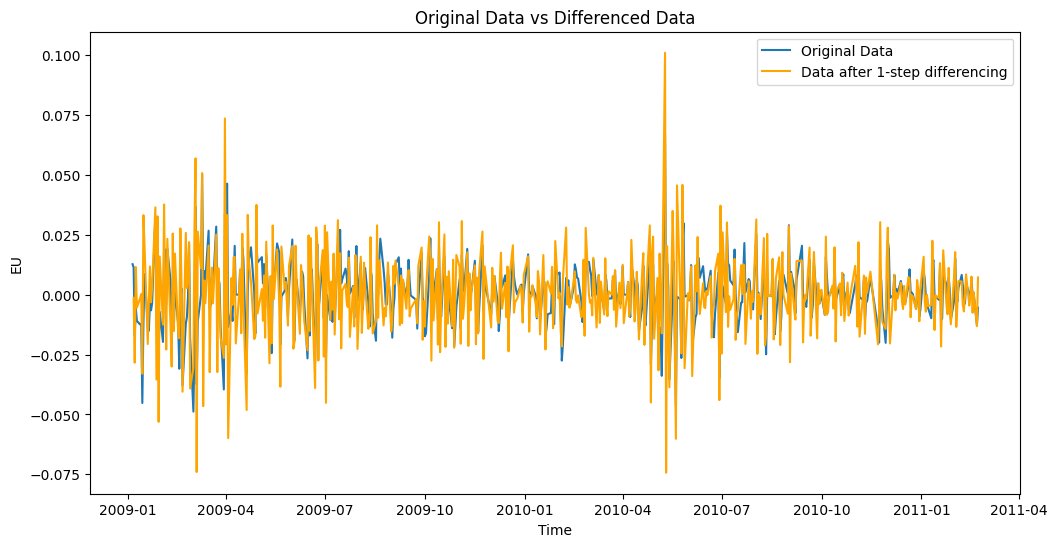

In [8]:
import matplotlib.pyplot as plt

# 设置0步差分
diff_steps = 1
df_diff = df['EU'].diff(diff_steps).dropna()

plt.figure(figsize=(12,6))

# 绘制原始数据
plt.plot(df['EU'], label='Original Data')

# 绘制1步差分后的数据
plt.plot(df_diff, label=f'Data after {diff_steps}-step differencing', color='orange')

# 设置标题和标签
plt.title('Original Data vs Differenced Data')
plt.xlabel('Time')
plt.ylabel('EU')

plt.legend()

plt.show()

In [9]:
df['EU_Diff_1'] = df['EU'].diff(1)

模型选择

1.分析ACF和PACF

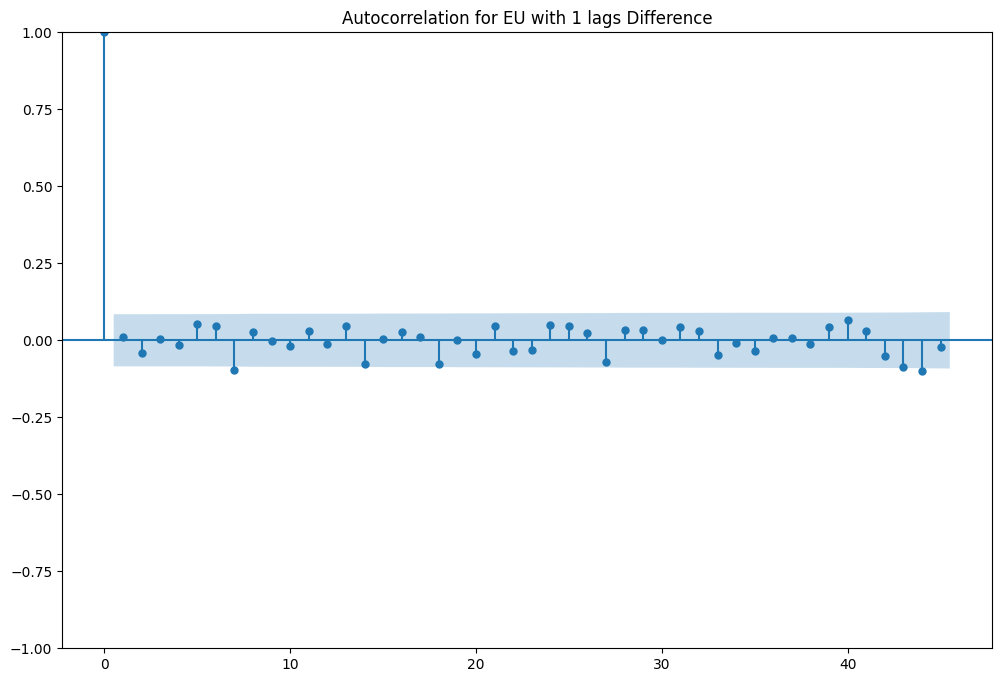

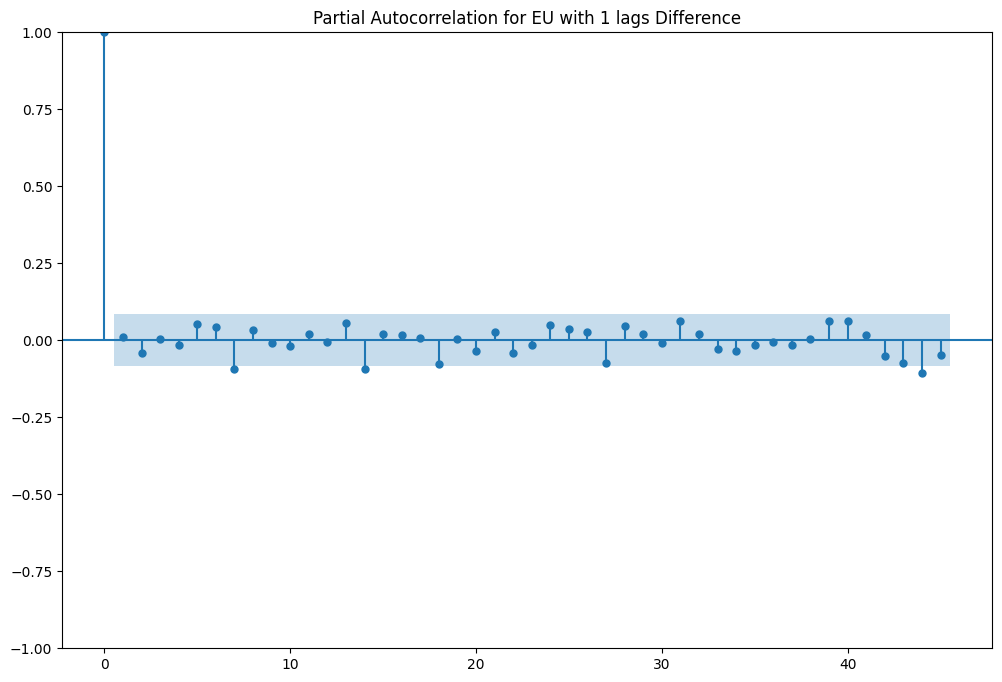

In [12]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 绘制ACF图
plt.figure(figsize=(12,8))
plot_acf(df['EU'].dropna(), lags=45, ax=plt.gca())
plt.title('Autocorrelation for EU with 1 lags Difference')
plt.show()

# 绘制PACF图
plt.figure(figsize=(12,8))
plot_pacf(df['EU'].dropna(), lags=45, ax=plt.gca())
plt.title('Partial Autocorrelation for EU with 1 lags Difference')
plt.show()

2.使用多阶差分获取d值

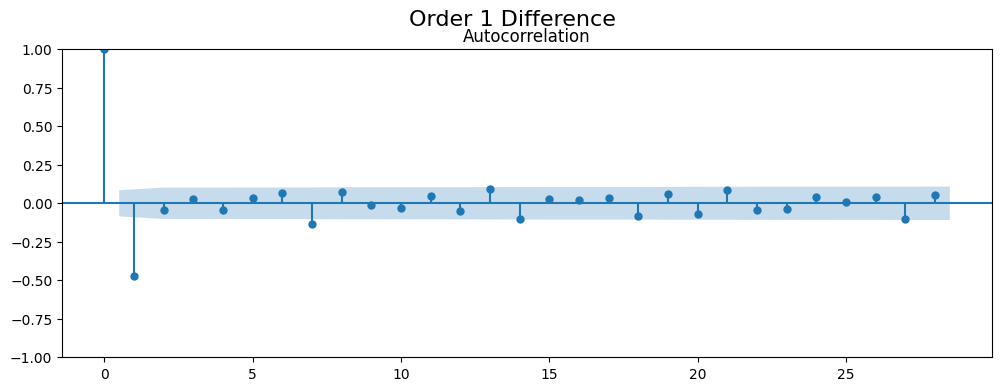

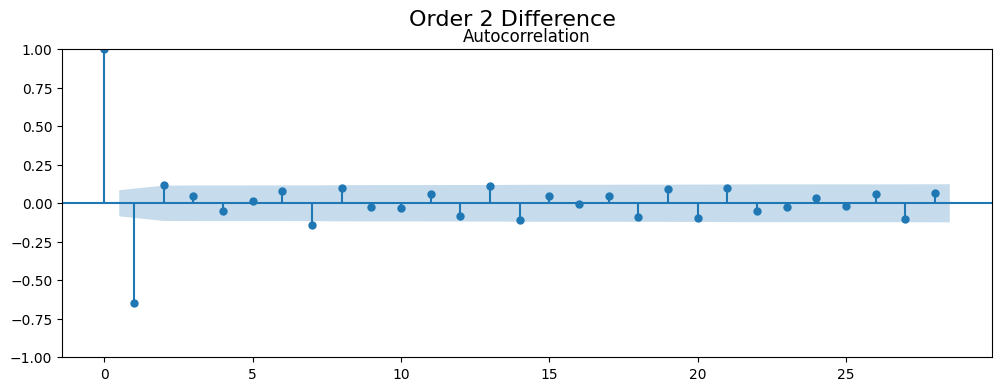

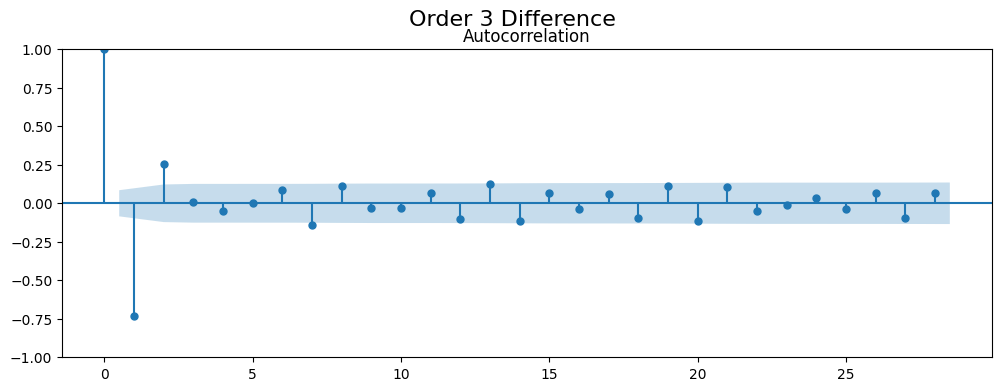

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import numpy as np

def diff(data, order):
    if order == 0:
        return data
    else:
        return diff(data.diff().dropna(), order - 1)

# 循环不同的d值
for d in range(1, 4):
    # 创建新的图形
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Order {d} Difference', fontsize=16)

    # 绘制ACF图
    plot_acf(diff(df['EU'], d), ax=plt.gca(), title='Autocorrelation')
    plt.show()

ARIMA模型实现

1.设置时间索引

In [14]:
df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)
df.index

DatetimeIndex(['2009-01-05', '2009-01-06', '2009-01-07', '2009-01-08',
               '2009-01-09', '2009-01-12', '2009-01-13', '2009-01-14',
               '2009-01-15', '2009-01-16',
               ...
               '2011-02-09', '2011-02-10', '2011-02-11', '2011-02-14',
               '2011-02-15', '2011-02-16', '2011-02-17', '2011-02-18',
               '2011-02-21', '2011-02-22'],
              dtype='datetime64[ns]', length=536, freq=None)

2.获取不同p、d、q值

In [15]:
import itertools
#定义p, d和q参数，取0到4之间的任意值
p = q = range(0, 4)

# 生成p, d和q三元组的所有不同组合
pdq = [(x[0], 0, x[1]) for x in list(itertools.product(p, q))]
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3)]

3.超参数获取

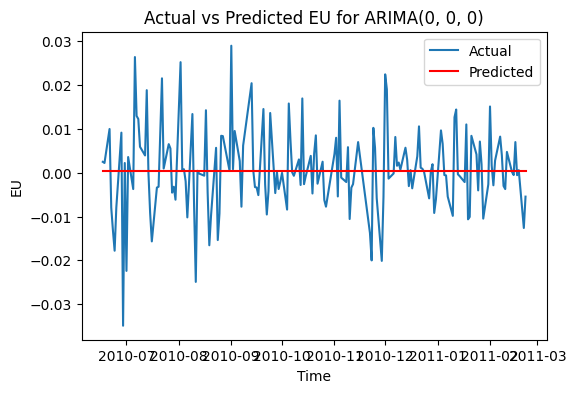

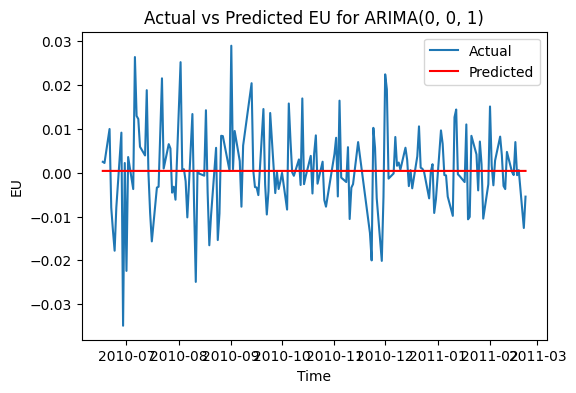

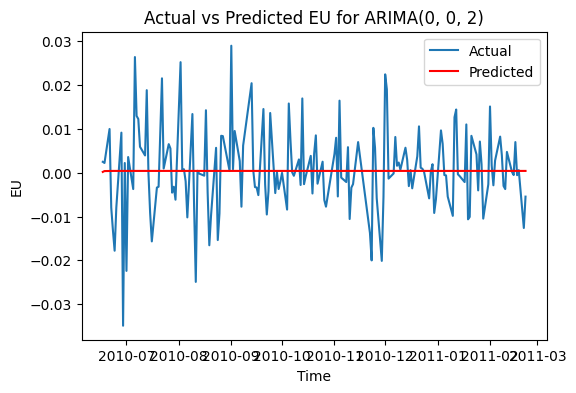

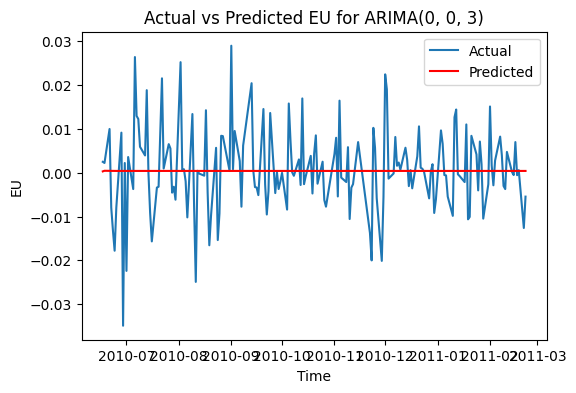

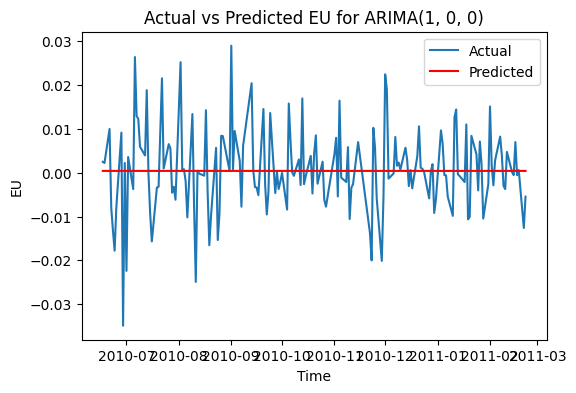

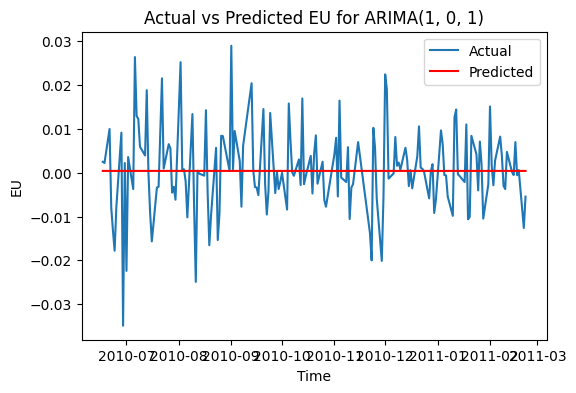

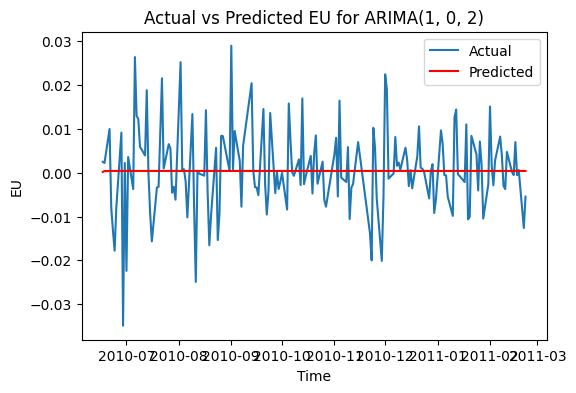

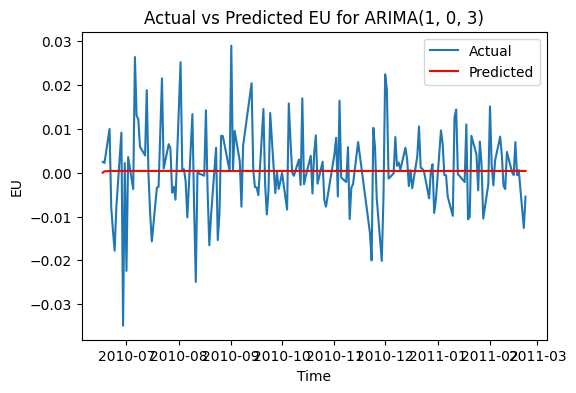

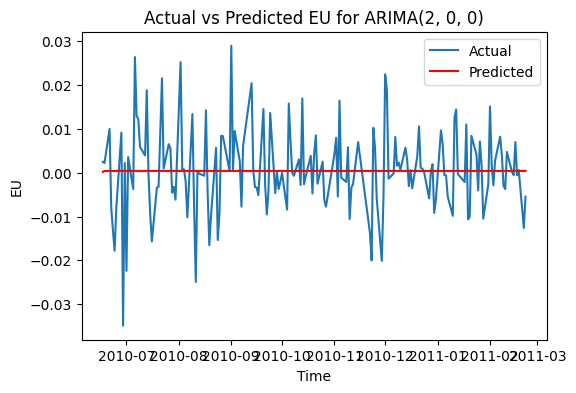

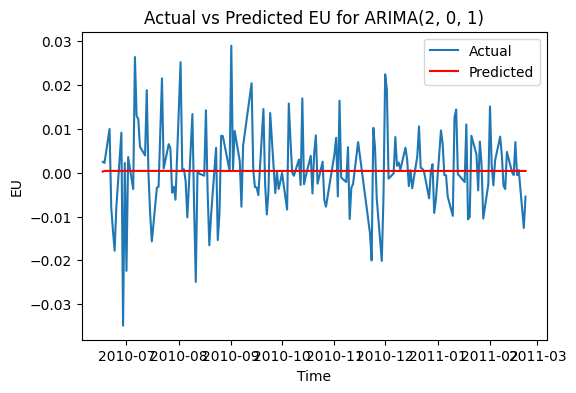

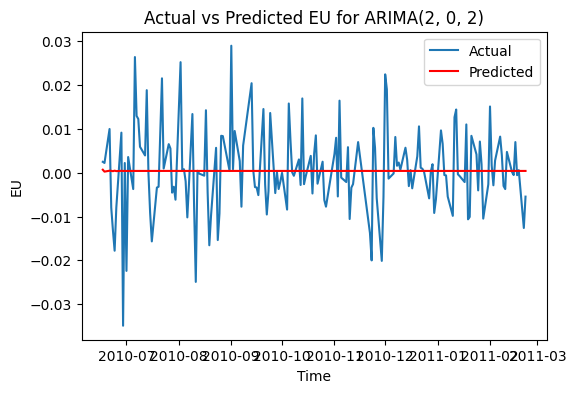

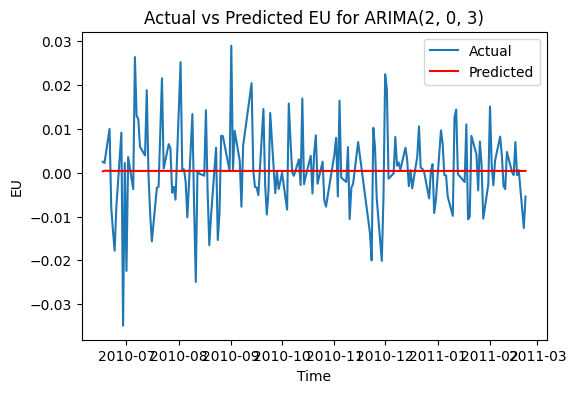

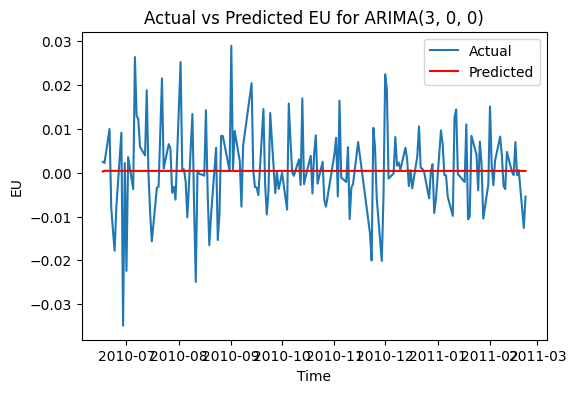

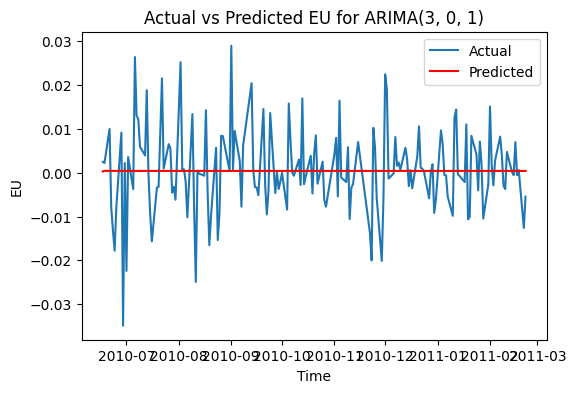

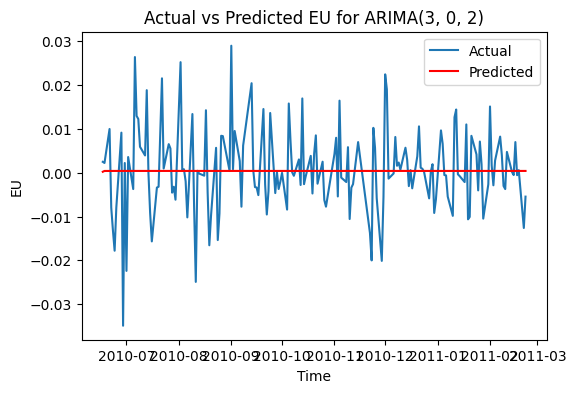

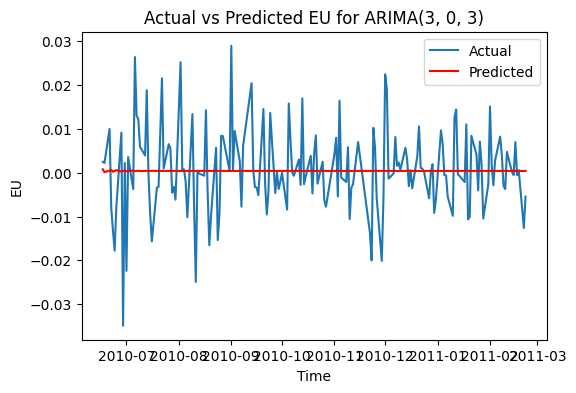

The best model is ARIMA(2, 0, 2), MSE = 9.165850787417911e-05
                               SARIMAX Results                                
Dep. Variable:                     EU   No. Observations:                  366
Model:                 ARIMA(2, 0, 2)   Log Likelihood                1036.104
Date:                Sat, 24 Feb 2024   AIC                          -2060.208
Time:                        23:44:51   BIC                          -2036.792
Sample:                             0   HQIC                         -2050.903
                                - 366                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.503      0.615      -0.001       0.002
ar.L1         -1.2591      1.248     -1.009      0.313      -3.705   

In [16]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import itertools

#定义p, d和q参数，取0到4之间的任意值
p = q = range(0, 4)

# 生成p, d和q三元组的所有不同组合
pdq = [(x[0], 0, x[1]) for x in list(itertools.product(p, q))]


# 将数据分为训练集和测试集
train_data = df['EU'].iloc[:366]
test_data = df['EU'].iloc[366:]


# 初始化最佳模型及其参数和MSE值
best_model = None
best_param = None
best_mse = float('inf')

# 对每一种参数组合进行迭代
for param in pdq:
    try:
        # 实例化ARIMA模型
        model = ARIMA(train_data, order=param)
        model_fit = model.fit()

        # 进行预测
        predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

        # 计算MSE
        mse = mean_squared_error(test_data, predictions)

        # 如果当前模型的MSE比最佳MSE小，更新最佳模型、参数和MSE
        if mse < best_mse:
            best_model = model_fit
            best_param = param
            best_mse = mse

        # 绘制真实值和预测值
        plt.figure(figsize=(6, 4))
        plt.plot(df.index[366:], df['EU'].iloc[366:], label='Actual')
        plt.plot(df.index[366:], predictions, color='red', label='Predicted')

        # 添加标题和标签
        plt.title('Actual vs Predicted EU for ARIMA{}'.format(param))
        plt.xlabel('Time')
        plt.ylabel('EU')
        plt.legend()

        # 显示图形
        plt.show()

    except Exception as e:
        print('Error:', e)
        continue

# 打印出最优模型的参数及其MSE
print(f'The best model is ARIMA{best_param}, MSE = {best_mse}')

# 打印最优模型的摘要
print(best_model.summary(alpha=0.05))

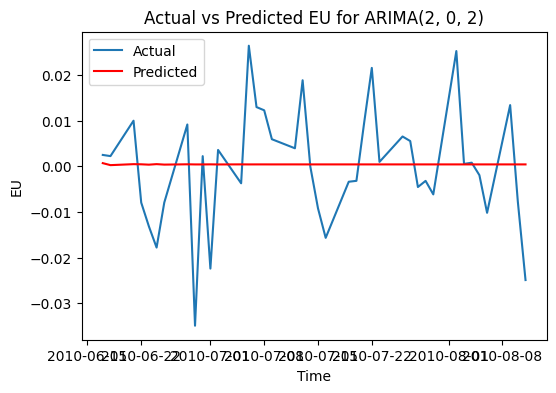

In [26]:
param = (2,0,2)
# 实例化ARIMA模型
model = ARIMA(train_data, order=param)
model_fit = model.fit()

# 进行预测
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

# 计算MSE
mse = mean_squared_error(test_data, predictions)

# 如果当前模型的MSE比最佳MSE小，更新最佳模型、参数和MSE
if mse < best_mse:
    best_model = model_fit
    best_param = param
    best_mse = mse

# 绘制真实值和预测值
plt.figure(figsize=(6, 4))
plt.plot(df.index[366:406], df['EU'].iloc[366:406], label='Actual')
plt.plot(df.index[366:406], predictions.iloc[:40], color='red', label='Predicted')

# 添加标题和标签
plt.title('Actual vs Predicted EU for ARIMA{}'.format(param))
plt.xlabel('Time')
plt.ylabel('EU')
plt.legend()

# 显示图形
plt.show()

SARIMA模型实现

ARIMA(0, 1, 0, 12) - AIC:-1753.6917343491618


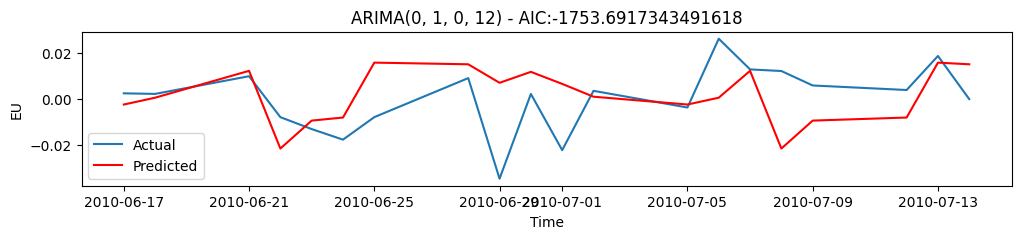

ARIMA(0, 1, 1, 12) - AIC:-1963.8931312292912


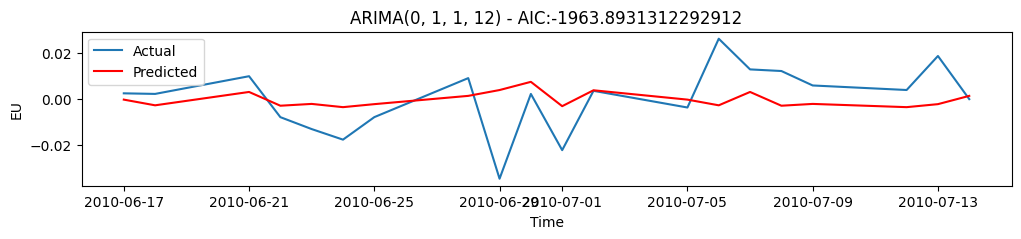

ARIMA(0, 1, 2, 12) - AIC:-1963.003772081558


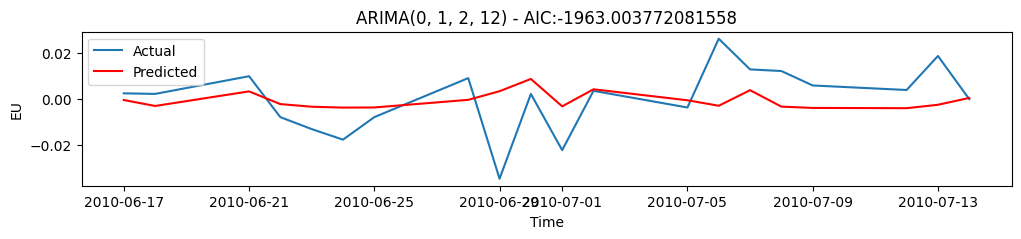

ARIMA(1, 1, 0, 12) - AIC:-1877.1687147495315


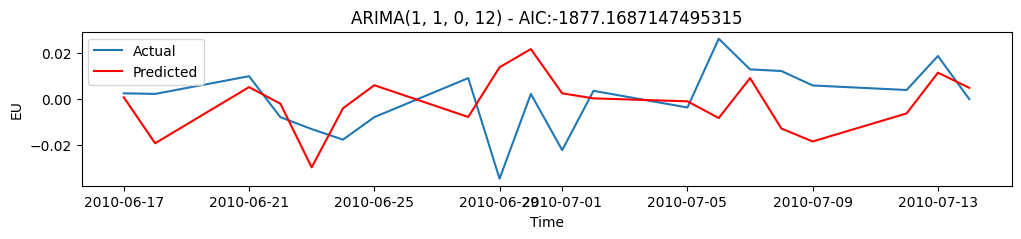

ARIMA(1, 1, 1, 12) - AIC:-1963.1084196047304


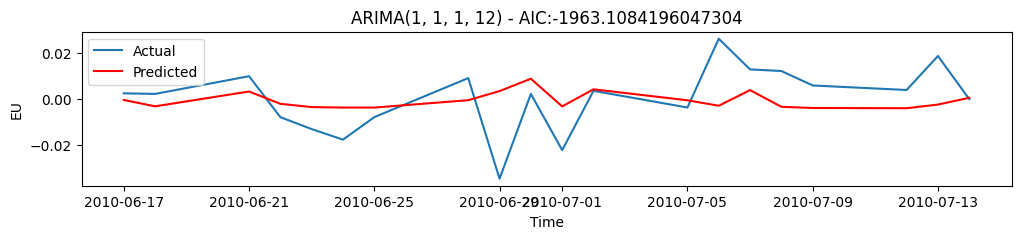

ARIMA(1, 1, 2, 12) - AIC:-1960.8227543982186


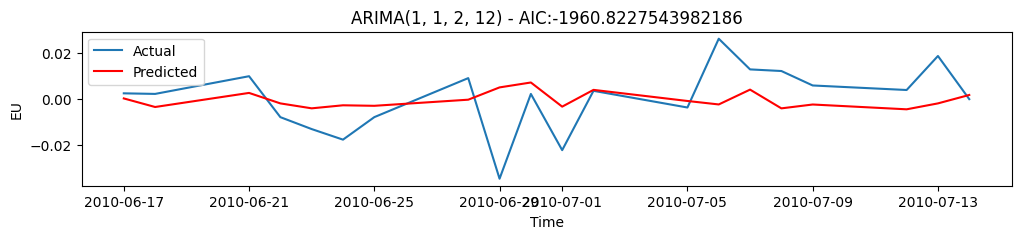

ARIMA(2, 1, 0, 12) - AIC:-1915.0714479664903


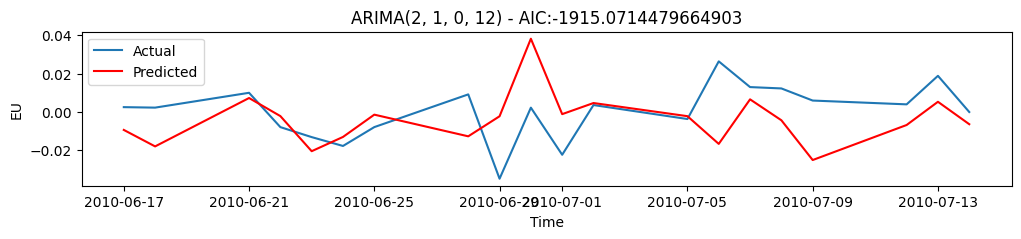

ARIMA(2, 1, 1, 12) - AIC:-1961.696558556604


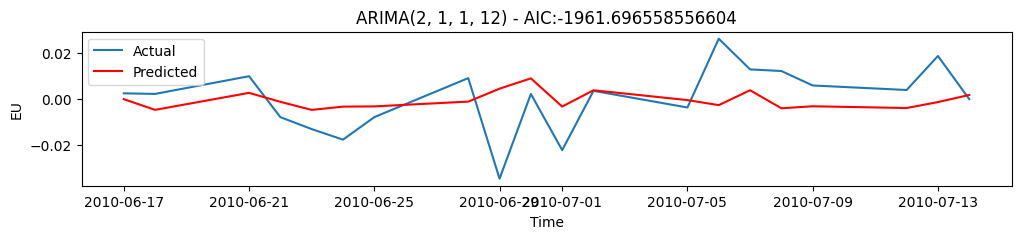

ARIMA(2, 1, 2, 12) - AIC:-1959.1554285415423


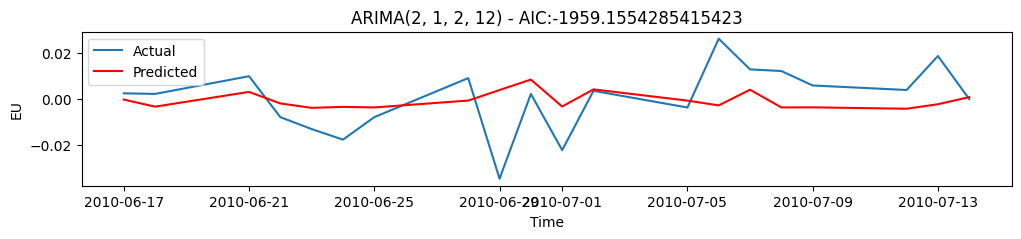


The best model is ARIMA(0, 1, 1, 12), AIC = -1963.8931312292912
                                SARIMAX Results                                 
Dep. Variable:                       EU   No. Observations:                  366
Model:             ARIMA(0, 1, [1], 12)   Log Likelihood                 983.947
Date:                  Sat, 24 Feb 2024   AIC                          -1963.893
Time:                          23:47:01   BIC                          -1956.155
Sample:                               0   HQIC                         -1960.814
                                  - 366                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.005      0.995]
------------------------------------------------------------------------------
ma.S.L12      -0.9233      0.050    -18.413      0.000      -1.052      -0.794
sigma2         0.0002   1.22e-05     17.295      0

In [17]:
import warnings
warnings.filterwarnings("ignore")  
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA  
import itertools

# 定义季节性参数 P 和 Q，取0到2之间的任意值
P = Q = range(0, 3)  # D固定为1
s = 12  # 季节性周期，这里设置为12，表示年度季节性

# 生成P和Q的组合，并创建季节性参数列表
seasonal_pdq = [(x[0], 1, x[1], s) for x in list(itertools.product(P, Q))]


# 将数据分为训练集和测试集
train_data = df['EU'][:366]  
test_data = df['EU'].iloc[366:]  

best_model = None  # 初始化最优模型
best_seasonal_param = None  # 初始化最优季节性参数
best_aic = float('inf')  # 初始化最优模型的AIC值，初始值设置为无穷大

# 对所有的季节性参数组合进行遍历
for seasonal_param in seasonal_pdq:
    try:
        # 建立季节性ARIMA模型
        model = ARIMA(endog = train_data, seasonal_order=seasonal_param)  
        model_fit = model.fit()  # 拟合模型

        aic = model_fit.aic  # 获取当前模型的AIC值

        # 如果当前模型的AIC小于最优AIC，则更新最优模型、最优季节性参数和最优AIC
        if aic < best_aic:
            best_model = model_fit
            best_seasonal_param = seasonal_param
            best_aic = aic

        print(f'ARIMA{seasonal_param} - AIC:{aic}')

        # 生成预测结果的开始时间和结束时间
        start = len(train_data)
        end = start + len(test_data) - 1

        # 使用当前模型进行预测
        predictions = model_fit.predict(start=start, end=end, dynamic=True)

        # 画图展示真实值和预测值
        plt.figure(figsize=(12, 2))
        plt.plot(df.index[366:386], df['EU'].iloc[366:386], label='Actual')
        plt.plot(df.index[366:386], predictions.iloc[:20], color='red', label='Predicted')

        plt.title(f'ARIMA{seasonal_param} - AIC:{aic}')
        plt.xlabel('Time')
        plt.ylabel('EU')
        plt.legend()

        plt.show()

    except Exception as e:
        # 如果建立模型或者拟合模型出错，打印出错误信息
        print('Error:', e)
        continue

# 打印出最优模型的季节性参数和AIC
print(f'\nThe best model is ARIMA{best_seasonal_param}, AIC = {best_aic}')

# 打印最优模型的摘要信息
print(best_model.summary(alpha=0.01))

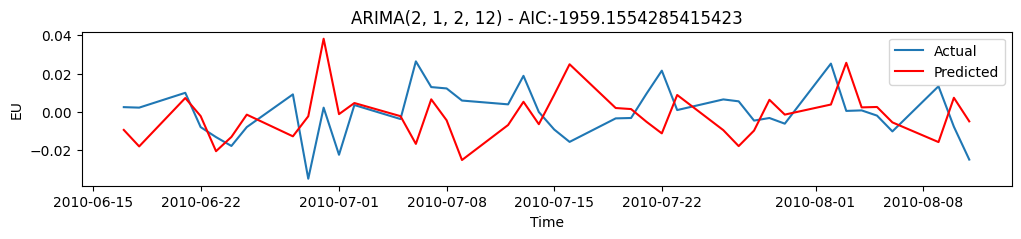

In [19]:
model = ARIMA(endog = train_data, seasonal_order=(2,1,0,12))  
model_fit = model.fit()  # 拟合模型

# 生成预测结果的开始时间和结束时间
start = len(train_data)
end = start + len(test_data) - 1

# 使用当前模型进行预测
predictions = model_fit.predict(start=start, end=end, dynamic=True)

# 画图展示真实值和预测值
plt.figure(figsize=(12, 2))
plt.plot(df.index[366:406], df['EU'].iloc[366:406], label='Actual')
plt.plot(df.index[366:406], predictions.iloc[:40], color='red', label='Predicted')

plt.title(f'ARIMA{seasonal_param} - AIC:{aic}')
plt.xlabel('Time')
plt.ylabel('EU')
plt.legend()

plt.show()

In [21]:
# 创建一个新的DataFrame来存储真实值和预测值
comparison_df = pd.DataFrame({'Actual': df['EU'].iloc[366:], 'Predicted': predictions})

# 打印比对结果
print(comparison_df.head(20))

                       Actual  Predicted
2010-06-17 00:00:00  0.002465        NaN
2010-06-18 00:00:00  0.002212        NaN
2010-06-21 00:00:00  0.009956        NaN
2010-06-22 00:00:00 -0.007961        NaN
2010-06-23 00:00:00 -0.013176        NaN
2010-06-24 00:00:00 -0.017801        NaN
2010-06-25 00:00:00 -0.007954        NaN
2010-06-28 00:00:00  0.009125        NaN
2010-06-29 00:00:00 -0.034903        NaN
2010-06-30 00:00:00  0.002202        NaN
2010-07-01 00:00:00 -0.022402        NaN
2010-07-02 00:00:00  0.003561        NaN
2010-07-05 00:00:00 -0.003739        NaN
2010-07-06 00:00:00  0.026363        NaN
2010-07-07 00:00:00  0.012938        NaN
2010-07-08 00:00:00  0.012233        NaN
2010-07-09 00:00:00  0.005906        NaN
2010-07-12 00:00:00  0.003920        NaN
2010-07-13 00:00:00  0.018808        NaN
2010-07-14 00:00:00 -0.000073        NaN


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 计算均方误差
mse = mean_squared_error(df['EU'].iloc[366:], predictions)
print("Mean Squared Error (MSE):", mse)

# 计算平均绝对误差
mae = mean_absolute_error(df['EU'].iloc[366:], predictions)
print("Mean Absolute Error (MAE):", mae)

# 计算均方根误差
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 0.00024569732109811735
Mean Absolute Error (MAE): 0.012154476269038289
Root Mean Squared Error (RMSE): 0.01567473512050897
